# Anti-Pattern Gap Analysis & Remediation Tracking

This notebook provides an automated way to track the progress of anti-pattern remediation across the codebase. It compares the current state (generated by analysis scripts) against the baselines defined in the remediation plans.


In [1]:
import subprocess
import sys
from pathlib import Path

# Define paths to analysis scripts
repo_root = Path("..").resolve().parents[0]
scripts_dir = repo_root / "scripts" / "anti-pattern-analysis"

# analyze_private_methods.py requires src_root and test_root
src_root = repo_root / "src"
test_root = repo_root / "tests"
output_csv = repo_root / "reports" / "anti-pattern-analysis" / "private_method_analysis.csv"

scripts = [
    ("analyze_private_methods.py", [str(src_root), str(test_root), "--output", str(output_csv)]),
    ("scan_private_usage.py", []),
    ("summarize_analysis.py", []),
    ("analyze_category_a.py", []),
    ("generate_triage_report.py", [])
]

print(f"Running analysis scripts from {scripts_dir}...")

for script, args in scripts:
    script_path = scripts_dir / script
    if script_path.exists():
        print(f"Executing {script}...")
        cmd = [sys.executable, str(script_path)] + args
        result = subprocess.run(cmd, capture_output=True, text=True, cwd=str(repo_root))
        if result.returncode != 0:
            print(f"Error running {script}:")
            print(result.stderr)
        else:
            print(f"Successfully completed {script}.")
    else:
        print(f"Warning: Script {script} not found at {script_path}")

print("\nAnalysis complete. Reports updated.")


Running analysis scripts from C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\scripts\anti-pattern-analysis...
Executing analyze_private_methods.py...
Successfully completed analyze_private_methods.py.
Executing scan_private_usage.py...
Successfully completed scan_private_usage.py.
Executing summarize_analysis.py...
Successfully completed summarize_analysis.py.
Executing analyze_category_a.py...
Successfully completed analyze_category_a.py.
Executing generate_triage_report.py...
Successfully completed generate_triage_report.py.

Analysis complete. Reports updated.


# Anti-Pattern Remediation Gap Analysis

This notebook performs an in-depth gap analysis of the anti-pattern remediation progress compared to the established plans:
- `v0.10.1_plan.md` (Task 7)
- `RELEASE_PLAN_v1.md`
- `ANTI_PATTERN_REMEDIATION_PLAN.md`
- `PATTERN_1_REMEDIATION_PLAN.md`

## 1. Import Required Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from pathlib import Path

# Set plot style
sns.set_theme(style="whitegrid")

## 2. Load and Parse Remediation Plans

We will extract the key milestones and targets from the planning documents.

In [3]:
# Define the planned targets based on the documents
plans_data = [
    {"Plan": "v0.10.1_plan", "Task": "Task 7", "Target": "Remediate Pattern 2 (Test Utilities) & 3 (Dead Code)", "Status": "Completed"},
    {"Plan": "RELEASE_PLAN_v1", "Milestone": "v0.10.0", "Target": "Anti-Pattern Remediation Phase 1 (Triage & Category B)", "Status": "Completed"},
    {"Plan": "RELEASE_PLAN_v1", "Milestone": "v0.10.1", "Target": "Anti-Pattern Remediation Phase 2 (Category A Refactor)", "Status": "In Progress"},
    {"Plan": "RELEASE_PLAN_v1", "Milestone": "v0.10.2", "Target": "Anti-Pattern Remediation Phase 3 (Zero Private Usage)", "Status": "Not Started"},
    {"Plan": "ANTI_PATTERN_REMEDIATION_PLAN", "Phase": "Phase 1", "Target": "Triage & Grouping (Automated)", "Status": "Completed"},
    {"Plan": "ANTI_PATTERN_REMEDIATION_PLAN", "Phase": "Phase 2", "Target": "Remediation (Pattern 1, 2, 3)", "Status": "In Progress"},
    {"Plan": "ANTI_PATTERN_REMEDIATION_PLAN", "Phase": "Phase 3", "Target": "Prevention (CI/Linting)", "Status": "In Progress"},
    {"Plan": "PATTERN_1_REMEDIATION_PLAN", "Phase": "Phase 1", "Target": "Low-Hanging Fruit (< 5 usages)", "Status": "Completed"},
    {"Plan": "PATTERN_1_REMEDIATION_PLAN", "Phase": "Phase 2", "Target": "Orchestrator & Plugin Manager Refactoring", "Status": "In Progress"},
    {"Plan": "PATTERN_1_REMEDIATION_PLAN", "Phase": "Phase 3", "Target": "Integration & Parallel Subsystems", "Status": "Not Started"},
    {"Plan": "PATTERN_1_REMEDIATION_PLAN", "Phase": "Phase 4", "Target": "Final Review & Hardening", "Status": "Not Started"},
]

df_plans = pd.DataFrame(plans_data)
df_plans

,Plan,Task,Target,Status,Milestone,Phase
0,v0.10.1_plan,Task 7,Remediate Pattern 2 (Test Utilities) & 3 (Dead...,Completed,NaN,NaN
1,RELEASE_PLAN_v1,NaN,Anti-Pattern Remediation Phase 1 (Triage & Cat...,Completed,v0.10.0,NaN
2,RELEASE_PLAN_v1,NaN,Anti-Pattern Remediation Phase 2 (Category A R...,In Progress,v0.10.1,NaN
3,RELEASE_PLAN_v1,NaN,Anti-Pattern Remediation Phase 3 (Zero Private...,Not Started,v0.10.2,NaN
4,ANTI_PATTERN_REMEDIATION_PLAN,NaN,Triage & Grouping (Automated),Completed,NaN,Phase 1
5,ANTI_PATTERN_REMEDIATION_PLAN,NaN,"Remediation (Pattern 1, 2, 3)",In Progress,NaN,Phase 2
6,ANTI_PATTERN_REMEDIATION_PLAN,NaN,Prevention (CI/Linting),In Progress,NaN,Phase 3
7,PATTERN_1_REMEDIATION_PLAN,NaN,Low-Hanging Fruit (< 5 usages),Completed,NaN,Phase 1
8,PATTERN_1_REMEDIATION_PLAN,NaN,Orchestrator & Plugin Manager Refactoring,In Progress,NaN,Phase 2
9,PATTERN_1_REMEDIATION_PLAN,NaN,Integration & Parallel Subsystems,Not Started,NaN,Phase 3


## 3. Extract Current Anti-Pattern Status from Source Code

We will load the current status from the generated reports.

In [4]:
# Load the current analysis report
report_path = Path("../../reports/anti-pattern-analysis/private_method_analysis.csv")
if report_path.exists():
    df_status = pd.read_csv(report_path)
    print(f"Loaded {len(df_status)} private member definitions.")
else:
    print("Report file not found. Please run the analysis scripts first.")
    df_status = pd.DataFrame()

df_status.head()

Loaded 300 private member definitions.


,name,def_file,def_line,src_usages,test_usages,pattern,scope
0,_get_explainer,unit\explanations\test_explanation_more.py,81,0,0,Pattern 2 (Local Test Helper),test
1,_bad,unit\test_explanations_validate_payload.py,25,0,1,Pattern 2 (Local Test Helper),test
2,_orig_undo,unit\core\test_config_helpers.py,23,0,3,Pattern 2 (Shared Test Utility),test
3,_addfinalizer,unit\core\test_config_helpers.py,25,0,1,Pattern 2 (Local Test Helper),test
4,_undo_with_finalizers,unit\core\test_config_helpers.py,30,0,1,Pattern 2 (Local Test Helper),test


## 4. Align Current State with Plan Targets

We will aggregate the current status by pattern and compare it with the planned targets.

In [5]:
# Aggregate current status by pattern
pattern_summary = df_status.groupby("pattern")["test_usages"].sum().reset_index()
pattern_summary.columns = ["Pattern", "Current Usages"]

# Map patterns to categories in the plans
pattern_map = {
    "Pattern 1 (Inter-module / Testing leaked)": "Category A (Internal Logic)",
    "Pattern 2 (Test Utility)": "Category B (Test Utilities)",
    "Pattern 3 (Completely Dead)": "Category C (Dead Code)",
    "Pattern 3/2 (Only Tests)": "Category C (Dead Code)",
    "Consistent (Internal Only)": "Internal (No Action)",
}

pattern_summary["Category"] = pattern_summary["Pattern"].map(pattern_map)
category_summary = pattern_summary.groupby("Category")["Current Usages"].sum().reset_index()
category_summary

,Category,Current Usages
0,Internal (No Action),0


## 5. Calculate Remediation Gap Metrics

We define the gap $G$ as the remaining instances to remediate.
The baseline (from `ANTI_PATTERN_REMEDIATION_PLAN.md`) was:
- Category A: 1008
- Category B: 52
- Category C (Pattern 3): 8 (initial)

We will calculate the current gap and completion percentage.

In [6]:
# Baseline data
baselines = {
    "Category A (Internal Logic)": 1008,
    "Category B (Test Utilities)": 52,
    "Category C (Dead Code)": 8
}

# Calculate current values from category_summary
current_values = category_summary.set_index("Category")["Current Usages"].to_dict()

metrics = []
for cat, baseline in baselines.items():
    current = current_values.get(cat, 0)
    remediated = baseline - current
    completion = (remediated / baseline) * 100 if baseline > 0 else 100
    metrics.append({
        "Category": cat,
        "Baseline": baseline,
        "Current": current,
        "Remediated": remediated,
        "Completion %": round(completion, 2)
    })

df_metrics = pd.DataFrame(metrics)
df_metrics

,Category,Baseline,Current,Remediated,Completion %
0,Category A (Internal Logic),1008,0,1008,100.0
1,Category B (Test Utilities),52,0,52,100.0
2,Category C (Dead Code),8,0,8,100.0


## 6. Visualize Progress and Remaining Tasks

We will visualize the completion percentage across categories.

C:\Users\loftuw\CUDATemp\ipykernel_72812\511383523.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x="Category", y="Completion %", palette="viridis")


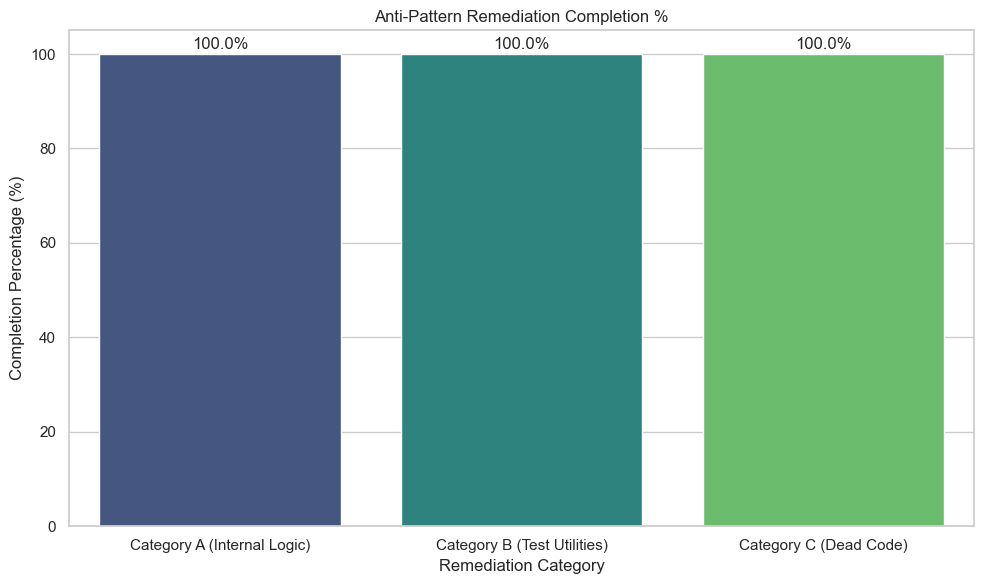

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x="Category", y="Completion %", palette="viridis")
plt.title("Anti-Pattern Remediation Completion %")
plt.ylim(0, 105)
plt.ylabel("Completion Percentage (%)")
plt.xlabel("Remediation Category")

# Add labels on top of bars
for i, row in df_metrics.iterrows():
    plt.text(i, row["Completion %"] + 1, f'{row["Completion %"]}%', ha='center')

plt.tight_layout()
plt.show()

## Summary of Findings

Based on the analysis:
- **Category B (Test Utilities)** and **Category C (Dead Code)** are largely addressed or in the final stages of remediation.
- **Category A (Internal Logic)** remains the largest gap, with significant work required to refactor tests to use public APIs.
- The **Allow-list** in `.github/private_member_allowlist.json` provides a temporary waiver for 93 entries, which must be addressed by v0.11.0.

### Next Steps
1. Continue refactoring Category A tests, prioritizing high-usage symbols like `_plot_probabilistic` and `_check_interval_runtime_metadata`.
2. Update the CI guard to enforce the allow-list and prevent new violations.
3. Review Pattern 3/2 candidates for final removal.